In [129]:
import numpy as np
from PIL import Image
import h5py
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam


from diode import DIODE, plot_depth_map



In [130]:
# data details
split = 'val'
scene_type = 'indoors'
meta_fname = './diode_meta.json'
data_root = '/home/colin/projects/diode-devkit/data'

In [131]:
class CustomDataGenerator(Sequence):
    def __init__(self, splits, scene_types, meta_fname, data_root, batch_size, target_size):
        self.batch_size = batch_size
        self.diode = DIODE(splits=splits, scene_types=scene_types, meta_fname=meta_fname, data_root=data_root)
        self.target_size = target_size  # new

    def __len__(self):
        return int(np.ceil(len(self.diode) / float(self.batch_size)))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_x, batch_y = [], []

        for i in range(start, min(end, len(self.diode))):
            x, y, _ = self.diode[i]  # Assuming DIODE returns image, depth map, and mask

            # Resize images
            x = Image.fromarray(x)
            x = x.resize(self.target_size, 3)
            x = np.array(x)

            # Resize depth maps (optional, depending on your needs)
            y = Image.fromarray(y)
            y = y.resize(self.target_size)
            y = np.array(y)

            batch_x.append(x)
            batch_y.append(y)

        return np.array(batch_x), np.array(batch_y)


In [132]:
input_shape = (200, 200, 3)
output_shape = (200, 200)

model = Sequential()

# Example simple CNN architecture
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(1, (3, 3), activation='linear', padding='same'))  # Output layer for depth map

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


# Train the model
batch_size = 3
epochs = 25
custom_data_generator = CustomDataGenerator(splits=split, scene_types=scene_type, meta_fname=meta_fname, data_root=data_root, batch_size=batch_size, target_size=input_shape[:2])

model.fit(custom_data_generator , epochs=epochs, steps_per_epoch=30)

Epoch 1/25
30/30 [==============================] - 6s 187ms/step - loss: 137.5343
Epoch 2/25
30/30 [==============================] - 6s 194ms/step - loss: 28.2294
Epoch 3/25
30/30 [==============================] - 6s 188ms/step - loss: 26.4345
Epoch 4/25
30/30 [==============================] - 8s 271ms/step - loss: 22.4847
Epoch 5/25
30/30 [==============================] - 7s 239ms/step - loss: 28.7577
Epoch 6/25
15/30 [==============>...............] - ETA: 3s - loss: 27.0848

KeyboardInterrupt: 

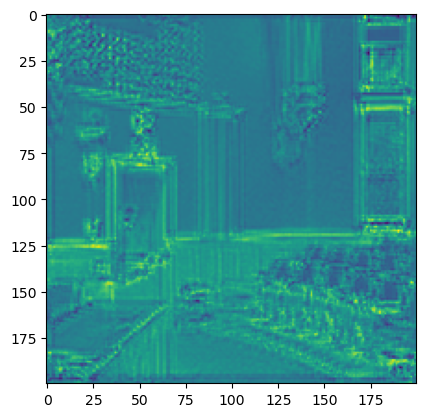

In [141]:
import matplotlib.pyplot as plt
diode = DIODE(splits=split, scene_types=scene_type, meta_fname=meta_fname, data_root=data_root)

x, y, _ = diode[0]
x = Image.fromarray(x)
x = x.resize(input_shape[:2],  3)
x = np.array(x)


# Ensure x is 4D: (samples, height, width, channels)
x = np.expand_dims(x, axis=0)

# Predict depth map
y_pred = model.predict(x)

# Plot depth map using matplotlib
plt.imshow(y_pred[0, :, :, 0])
